# VAEs: Testing Additive, Multiplicative, Softmax models on VAE samples, manipulating frequency and reconstruction loss

## Structure of the notebook
#### Part I: Pilot
#####  Summary
First, train a series of VAEs, where in each case, we vary the proportion of training examples (0s vs. 7s) and the loss penalty for incorrectly classifying 0s vs. 7s for the VAE. 

Then, use the VAE to create 10,000 samples of digits, and apply the CNN classifier to classify these generated samples as either 0s or 7s. 

Lastly, for each 10,000 samples, compute the proportion of samples that are 0s vs. 7s. Plot this proportion, as a function of the proportion of training data of 0s, and as a function of loss penalty applied to incorrectly classification of 0s vs. 7s. 


##### I. 1. Define VAE architecture 
##### I. 2. Define functions to vary the proportion of training examples (0s vs. 7s) and loss penalties for mis-classifying 0s vs. 7s
##### I. 3. Train a CNN classifier, to classify a VAE-generated digit as either a 0 or a 7
##### I. 4. Run the Experiment
##### I. 5. Plot the results
##### ==========================================================================



#### Part II: Generate experimental data
##### Summary
Same experiment as pilot, with the main difference: for each VAE, instead of generating 10,000 samples, classifying each of them with a VAE and only looking at the proportion of 0s, we now put all 10,000 classified samples from each VAE into a single big dataframe, and then in part III. we fit the models on this large dataframe. 

##### II. 1. Define VAE architecture 
##### II. 2. Define functions to vary the proportion of training examples (0s vs. 7s) and loss penalties for mis-classifying 0s vs. 7s
##### II. 3. Train a CNN classifier, to classify a VAE-generated digit as either a 0 or a 7
##### II. 4. Run the Experiment
##### II. 5. Save the data
##### ==========================================================================


#### Part III: Fit the data to the three models (Additive, Multiplicative, Softmax)

##### III. 1. Load the data
##### III. 2. Fit the additive model
##### III. 3. Fit the multiplicative model
##### III. 4. Fit the softmax model
##### III. 5. Validate negative log likelihood for each model
##### III. 6. Calculate AIC & BIC scores for each model 
##### III. 7. Results summary
##### ==========================================================================

## I. Pilot

## I. 1. Define VAE architecture

In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Subset, ConcatDataset, DataLoader
from tqdm.notebook import tqdm
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128
INPUT_DIM = 784
H_DIM = 784
Z_DIM = 2
NUM_EPOCHS = 25
LR_RATE = 1e-3
# penalized_factor = 100
# penalized_list = [0]  # Apply a penalty to digit 0
# non_penalized_list = [7]  # Apply a penalty to digit 0

full_dataset = datasets.MNIST(root='dataset', train=True, transform=ToTensor(), download=True)

In [128]:
## Common VAE architecture
#MODEL
#Input image --> Hidden dim --> mean, std --> Parametrization trick --> Decoder --> Output image
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim = 200, z_dim = 20):
        super().__init__()

        #take image: convert to hidden dim
        self.img_2hid = nn.Linear(input_dim, hidden_dim)
        #encoder: encode to mean and std
        self.hid_2mu = nn.Linear(hidden_dim, z_dim)
        self.hid_2sigma = nn.Linear(hidden_dim, z_dim)

        #decoder: decode to image
        #first: flatten: z to hidden dim
        self.z_2hid = nn.Linear(z_dim, hidden_dim)
        #second, hidden dim to image
        self.hid_2img = nn.Linear(hidden_dim, input_dim)

        #define relu
        self.relu = nn.ReLU()

        
    def encode(self, x):
        #q_phi(z|x)
        
        #flatten
        h = self.relu(self.img_2hid(x))
        
        #get mean, var
        mu = self.hid_2mu(h)
        
        #get variance (and ensure it's positive with softplus)
        #sigma = self.hid_2sigma(h)
        sigma = F.softplus(self.hid_2sigma(h))
    
        return mu, sigma


    def decode(self, z):
        #p_theta(x|z)
        
        #flatten the latent
        h = self.relu(self.z_2hid(z))
        
        #decode
        decoded = self.hid_2img(h)

        return torch.sigmoid(decoded)

    def forward(self, x):
        #encode
        mu, sigma = self.encode(x)

        #before decoding: use reparametrization trick
        epsilon = torch.randn_like(sigma)
        z_reparametrized = mu + sigma*epsilon

        #decode
        x_reconstructed = self.decode(z_reparametrized)

        #need mu, sigma for loss
        return x_reconstructed, mu, sigma

## II. 2. Define functions to vary the proportion of training examples (0s vs. 7s) and loss penalties for mis-classifying 0s vs. 7s

In [129]:
## 1. Vary the proportion of training examples
def create_custom_dataset(full_dataset, digit_proportions):
    # digit_proportions: dictionary with digits as keys and their desired proportions as values, e.g., {0: 0.7, 7: 0.3}
    
    # Filter datasets for each digit
    digit_datasets = {}
    for digit, proportion in digit_proportions.items():
        indices = (full_dataset.targets == digit)
        digit_datasets[digit] = Subset(full_dataset, np.where(indices)[0])

    # Calculate the maximum allowable total size
    min_size_ratio = min([len(digit_datasets[digit]) / proportion for digit, proportion in digit_proportions.items()])
    total_size = int(min_size_ratio)
    
    # Calculate the number of samples for each digit based on the adjusted total size
    digit_sizes = {digit: int(proportion * total_size) for digit, proportion in digit_proportions.items()}
    
    # Adjust sizes to not exceed available images for each digit
    for digit, size in digit_sizes.items():
        available_images = len(digit_datasets[digit])
        if size > available_images:
            print(f"Requested size for digit {digit} exceeds available images. Adjusting from {size} to {available_images}.")
            digit_sizes[digit] = available_images
    
    # Create the custom dataset by sampling from each digit's dataset
    custom_datasets = [Subset(digit_datasets[digit], np.random.choice(len(digit_datasets[digit]), size, replace=False)) for digit, size in digit_sizes.items()]
    combined_dataset = ConcatDataset(custom_datasets)
    
    return combined_dataset

In [140]:
def train_vae_with_penalty(model, train_loader, device, input_dim, num_epochs, lr_rate, penalized_factor, penalized_list):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
    loss_fn = nn.BCELoss(reduction='none')  # Using BCELoss with reduction set to 'none' for element-wise loss

    for epoch in range(num_epochs):
        loop = tqdm(train_loader, total=len(train_loader), leave=True, disable=True)
        for x, y in loop:
            x = x.to(device).view(x.shape[0], input_dim)
            x_reconstructed, mu, sigma = model(x)
            
            # Compute element-wise reconstruction loss and sum it
            reconstruction_losses = loss_fn(x_reconstructed, x)
            
            # Apply the penalty based on the digit list
            for idx in range(reconstruction_losses.shape[0]):
                if y[idx].item() in penalized_list:
                    reconstruction_losses[idx, :] *= penalized_factor
            reconstruction_loss = reconstruction_losses.sum()
            
            # Compute KL divergence for each sample in the batch
            KL_divergence = 0.5 * torch.sum(sigma.pow(2) + mu.pow(2) - 1 - torch.log(sigma.pow(2)))
        
            # Total loss is the sum of reconstruction loss and KL divergence
            total_loss = reconstruction_loss + KL_divergence
            
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            loop.set_description(f"Epoch [{epoch + 1}/{num_epochs}]")
            loop.set_postfix(loss=total_loss.item())

In [11]:
## Define the sampling function
def sample_from_vae(model, num_samples=1000, z_dim=2, device=torch.device('cpu')):  # Adjusted to 64 for 8x8 samples
    # 1. Sample from the prior distribution (standard normal)
    z = torch.randn(num_samples, Z_DIM).to(device)
    
    # 2. Decode the latent variables to generate images
    samples = model.decode(z)
    
    return samples.cpu().view(-1, 28, 28).detach().numpy()

## II. 3. Train a CNN classifier, to classify a VAE-generated digit as either a 0 or a 7

In [132]:
# CNN Classifier
import torch.optim as optim

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(7*7*64, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 7*7*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def train_CNN_classifier(model):
    # Load the MNIST dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    num_epochs = 5  # You might need more epochs for better performance
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


def test_CNN_classifier(model):
    test_dataset = datasets.MNIST(root='./data', train=False, download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5,), (0.5,))
                         ]))
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Inference mode, no gradients needed
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Accuracy of the CNN on the MNIST test images: {accuracy * 100}%')

    
# Initialize the model and train it
CNN_classifier = CNNClassifier().to(device)
train_CNN_classifier(model = CNN_classifier)
test_CNN_classifier(model = CNN_classifier)

Epoch [1/5], Loss: 0.1285
Epoch [2/5], Loss: 0.0009
Epoch [3/5], Loss: 0.0096
Epoch [4/5], Loss: 0.0063
Epoch [5/5], Loss: 0.0000
Accuracy of the CNN on the MNIST test images: 98.76%


In [137]:
## 4. Create a function to analyze the samples (analyze_samples)
def analyze_samples(samples, classifier, device):
    classifier.eval()  # Ensure the classifier is in evaluation mode
    samples_tensor = torch.tensor(samples, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    samples_tensor = samples_tensor.to(device)
    
    with torch.no_grad():
        outputs = classifier(samples_tensor)
        _, predicted_labels = torch.max(outputs, 1)
        predicted_labels = predicted_labels.cpu().numpy()
    
    counts = Counter(predicted_labels)
    total = sum(counts.values())
    proportion_0s = counts[0] / total if 0 in counts else 0
    proportion_7s = counts[7] / total if 7 in counts else 0
    
    return {'0': proportion_0s, '7': proportion_7s}

## II. 4. Run the experiment

In [134]:
def analyze_results(results):
    # This is a placeholder for your analysis code
    # You might perform statistical analysis or generate plots here
    for result in results:
        print(f"Frequency: {result['frequency']}, Penalty: {result['penalty']}, Proportions: {result['proportions']}")
    
    # Example: Plot results, perform regression analysis, etc.

In [135]:
def run_experiment(digit_proportions, penalized_factor, penalized_list, classifier):
    # Step 1: Create custom dataset with specified digit proportions
    custom_dataset = create_custom_dataset(full_dataset, digit_proportions)
    train_loader = DataLoader(custom_dataset, batch_size=128, shuffle=True)
    
    # Step 2: Train VAE with specified penalty factor
    model = VariationalAutoEncoder(INPUT_DIM, H_DIM, Z_DIM).to(device)
    train_vae_with_penalty(model=model, train_loader=train_loader, device=device,
                           input_dim=INPUT_DIM, num_epochs=NUM_EPOCHS,
                           lr_rate=LR_RATE, penalized_factor=penalized_factor,
                           penalized_list=penalized_list)
    
    # Step 3: Generate samples from the trained VAE
    samples = sample_from_vae(model, num_samples=1000, z_dim=Z_DIM, device=device)
        
    # Step 4: Analyze the generated samples to calculate the proportion of each digit
    proportions = analyze_samples(samples, classifier = classifier, device = device)
    return proportions

In [144]:
#for 0
digit_frequencies = np.linspace(0, 1, 21)
digit_penalties = [1, 10, 50, 100, 200, 500, 1000]

# digit_frequencies = np.linspace(0, 1, 1)
# digit_penalties = [1, 10, 50]

In [145]:
results = []
# Example loop for varying conditions - adjust ranges as needed
for frequency in digit_frequencies:
    for penalty in digit_penalties:
        digit_proportions = {0: frequency, 7: 1-frequency}
        proportions = run_experiment(digit_proportions, penalty, penalized_list, classifier = CNN_classifier)
        results.append({'frequency': frequency, 'penalty': penalty, 'proportions': proportions})
        print({'frequency': frequency, 'penalty': penalty, 'proportions': proportions})
        
# Step 5: Analyze the results to look for multiplicative patterns
analyze_results(results)

/var/folders/kq/690dvspn7dv8y9zql829_bhr0000gn/T/ipykernel_62706/3103586417.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  min_size_ratio = min([len(digit_datasets[digit]) / proportion for digit, proportion in digit_proportions.items()])


{'frequency': 0.0, 'penalty': 1, 'proportions': {'0': 0, '7': 0.962}}
{'frequency': 0.0, 'penalty': 10, 'proportions': {'0': 0, '7': 0.954}}
{'frequency': 0.0, 'penalty': 50, 'proportions': {'0': 0, '7': 0.961}}
{'frequency': 0.0, 'penalty': 100, 'proportions': {'0': 0, '7': 0.989}}
{'frequency': 0.0, 'penalty': 200, 'proportions': {'0': 0, '7': 0.97}}
{'frequency': 0.0, 'penalty': 500, 'proportions': {'0': 0, '7': 0.965}}
{'frequency': 0.0, 'penalty': 1000, 'proportions': {'0': 0, '7': 0.958}}
{'frequency': 0.05, 'penalty': 1, 'proportions': {'0': 0.11, '7': 0.885}}
{'frequency': 0.05, 'penalty': 10, 'proportions': {'0': 0.371, '7': 0.625}}
{'frequency': 0.05, 'penalty': 50, 'proportions': {'0': 0.615, '7': 0.383}}
{'frequency': 0.05, 'penalty': 100, 'proportions': {'0': 0.761, '7': 0.239}}
{'frequency': 0.05, 'penalty': 200, 'proportions': {'0': 0.747, '7': 0.214}}
{'frequency': 0.05, 'penalty': 500, 'proportions': {'0': 0.919, '7': 0.081}}
{'frequency': 0.05, 'penalty': 1000, 'propo

In [151]:
print(df)

     frequency  penalty  proportion_0s
0          0.0        1          0.000
1          0.0       10          0.000
2          0.0       50          0.000
3          0.0      100          0.000
4          0.0      200          0.000
..         ...      ...            ...
142        1.0       50          1.000
143        1.0      100          0.997
144        1.0      200          0.999
145        1.0      500          0.999
146        1.0     1000          1.000

[147 rows x 3 columns]


## I. 5. Plot the results

/var/folders/kq/690dvspn7dv8y9zql829_bhr0000gn/T/ipykernel_62706/679181644.py:15: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.lineplot(data=df, x='frequency', y='proportion_0s', hue='penalty', marker='o', palette=bright_palette)


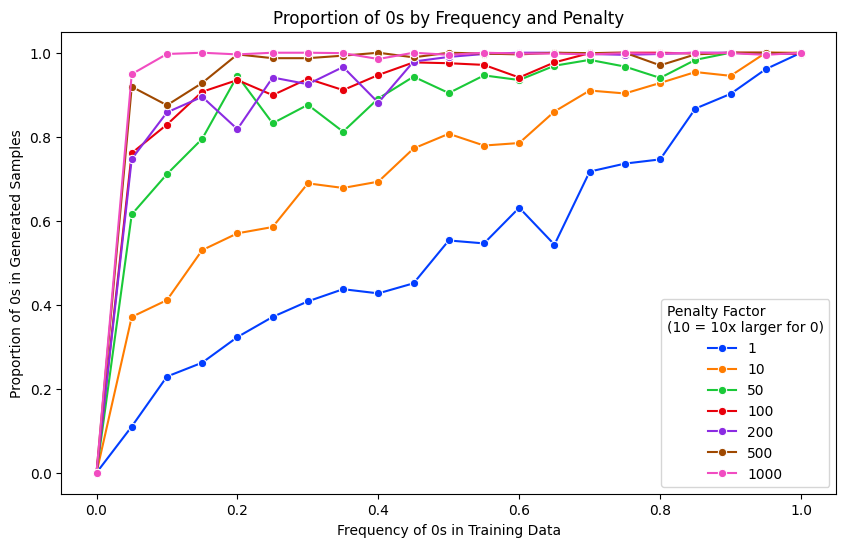

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a bright color palette
bright_palette = sns.color_palette("bright")

# You can also create a custom palette with specific colors
# For example: bright_palette = ["#FF0000", "#00FF00", "#0000FF", "#FF00FF"]

# Set the palette in seaborn
sns.set_palette(bright_palette)

# Assuming 'df' is the DataFrame from the statistical analysis part
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='frequency', y='proportion_0s', hue='penalty', marker='o', palette=bright_palette)
plt.title('Proportion of 0s by Frequency and Penalty')
plt.xlabel('Frequency of 0s in Training Data')
plt.ylabel('Proportion of 0s in Generated Samples')
plt.legend(title='Penalty Factor\n(10 = 10x larger for 0)')

# Save the figure
plt.savefig('graphs/proportion_of_0s_by_frequency_and_penalty.png', dpi=300)  # Adjust the filename and dpi as needed
plt.show()

# Part II: Generate a big dataframe, looking at each sampled element instead of proportion

## II. 1. Define VAE architecture 

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Subset, ConcatDataset, DataLoader
from tqdm.notebook import tqdm
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128
INPUT_DIM = 784
H_DIM = 784
Z_DIM = 2
NUM_EPOCHS = 25
LR_RATE = 1e-3
# penalized_factor = 100
# penalized_list = [0]  # Apply a penalty to digit 0
# non_penalized_list = [7]  # Apply a penalty to digit 0

full_dataset = datasets.MNIST(root='dataset', train=True, transform=ToTensor(), download=True)

In [19]:
## Common VAE architecture
#MODEL
#Input image --> Hidden dim --> mean, std --> Parametrization trick --> Decoder --> Output image
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim = 200, z_dim = 20):
        super().__init__()

        #take image: convert to hidden dim
        self.img_2hid = nn.Linear(input_dim, hidden_dim)
        #encoder: encode to mean and std
        self.hid_2mu = nn.Linear(hidden_dim, z_dim)
        self.hid_2sigma = nn.Linear(hidden_dim, z_dim)

        #decoder: decode to image
        #first: flatten: z to hidden dim
        self.z_2hid = nn.Linear(z_dim, hidden_dim)
        #second, hidden dim to image
        self.hid_2img = nn.Linear(hidden_dim, input_dim)

        #define relu
        self.relu = nn.ReLU()

        
    def encode(self, x):
        #q_phi(z|x)
        
        #flatten
        h = self.relu(self.img_2hid(x))
        
        #get mean, var
        mu = self.hid_2mu(h)
        
        #get variance (and ensure it's positive with softplus)
        #sigma = self.hid_2sigma(h)
        sigma = F.softplus(self.hid_2sigma(h))
    
        return mu, sigma


    def decode(self, z):
        #p_theta(x|z)
        
        #flatten the latent
        h = self.relu(self.z_2hid(z))
        
        #decode
        decoded = self.hid_2img(h)

        return torch.sigmoid(decoded)

    def forward(self, x):
        #encode
        mu, sigma = self.encode(x)

        #before decoding: use reparametrization trick
        epsilon = torch.randn_like(sigma)
        z_reparametrized = mu + sigma*epsilon

        #decode
        x_reconstructed = self.decode(z_reparametrized)

        #need mu, sigma for loss
        return x_reconstructed, mu, sigma

## II. 2. Define functions to vary the proportion of training examples (0s vs. 7s) and loss penalties for mis-classifying 0s vs. 7s

In [20]:
## 1. Vary the proportion of training examples
def create_custom_dataset(full_dataset, digit_proportions):
    # digit_proportions: dictionary with digits as keys and their desired proportions as values, e.g., {0: 0.7, 7: 0.3}
    
    # Filter datasets for each digit
    digit_datasets = {}
    for digit, proportion in digit_proportions.items():
        indices = (full_dataset.targets == digit)
        digit_datasets[digit] = Subset(full_dataset, np.where(indices)[0])

    # Calculate the maximum allowable total size
    min_size_ratio = min([len(digit_datasets[digit]) / proportion for digit, proportion in digit_proportions.items()])
    total_size = int(min_size_ratio)
    
    # Calculate the number of samples for each digit based on the adjusted total size
    digit_sizes = {digit: int(proportion * total_size) for digit, proportion in digit_proportions.items()}
    
    # Adjust sizes to not exceed available images for each digit
    for digit, size in digit_sizes.items():
        available_images = len(digit_datasets[digit])
        if size > available_images:
            print(f"Requested size for digit {digit} exceeds available images. Adjusting from {size} to {available_images}.")
            digit_sizes[digit] = available_images
    
    # Create the custom dataset by sampling from each digit's dataset
    custom_datasets = [Subset(digit_datasets[digit], np.random.choice(len(digit_datasets[digit]), size, replace=False)) for digit, size in digit_sizes.items()]
    combined_dataset = ConcatDataset(custom_datasets)
    
    return combined_dataset

In [21]:
def train_vae_with_penalty(model, train_loader, device, input_dim, num_epochs, lr_rate, penalized_factor, penalized_list):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
    loss_fn = nn.BCELoss(reduction='none')  # Using BCELoss with reduction set to 'none' for element-wise loss

    for epoch in range(num_epochs):
        loop = tqdm(train_loader, total=len(train_loader), leave=True, disable=True)
        for x, y in loop:
            x = x.to(device).view(x.shape[0], input_dim)
            x_reconstructed, mu, sigma = model(x)
            
            # Compute element-wise reconstruction loss and sum it
            reconstruction_losses = loss_fn(x_reconstructed, x)
            
            # Apply the penalty based on the digit list
            for idx in range(reconstruction_losses.shape[0]):
                if y[idx].item() in penalized_list:
                    reconstruction_losses[idx, :] *= penalized_factor
            reconstruction_loss = reconstruction_losses.sum()
            
            # Compute KL divergence for each sample in the batch
            KL_divergence = 0.5 * torch.sum(sigma.pow(2) + mu.pow(2) - 1 - torch.log(sigma.pow(2)))
        
            # Total loss is the sum of reconstruction loss and KL divergence
            total_loss = reconstruction_loss + KL_divergence
            
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            loop.set_description(f"Epoch [{epoch + 1}/{num_epochs}]")
            loop.set_postfix(loss=total_loss.item())

In [22]:
## Define the sampling function
def sample_from_vae(model, num_samples=1000, z_dim=2, device=torch.device('cpu')):  # Adjusted to 64 for 8x8 samples
    # 1. Sample from the prior distribution (standard normal)
    z = torch.randn(num_samples, Z_DIM).to(device)
    
    # 2. Decode the latent variables to generate images
    samples = model.decode(z)
    
    return samples.cpu().view(-1, 28, 28).detach().numpy()

In [24]:
## 4. Create a function to analyze the samples (analyze_samples)
#new: return a list with labels for each sampled digit from VAE
def analyze_samples(samples, classifier, device):
    classifier.eval()
    samples_tensor = torch.tensor(samples, dtype=torch.float32).unsqueeze(1)
    samples_tensor = samples_tensor.to(device)
    
    digit_sampled = []
    with torch.no_grad():
        outputs = classifier(samples_tensor)
        _, predicted_labels = torch.max(outputs, 1)
        digit_sampled.extend(predicted_labels.cpu().numpy())
        
    return digit_sampled

In [25]:
def analyze_results(results):
    for result in results:
        print(f"Frequency: {result['frequency']}, Penalty: {result['penalty']}, Proportions: {result['proportions']}")
    
    # Example: Plot results, perform regression analysis, etc.

## II. 3. Train a CNN classifier, to classify a VAE-generated digit as either a 0 or a 7

In [9]:
# CNN Classifier
import torch.optim as optim

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(7*7*64, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 7*7*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def train_CNN_classifier(model):
    # Load the MNIST dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    num_epochs = 5  # You might need more epochs for better performance
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


def test_CNN_classifier(model):
    test_dataset = datasets.MNIST(root='./data', train=False, download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5,), (0.5,))
                         ]))
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Inference mode, no gradients needed
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Accuracy of the CNN on the MNIST test images: {accuracy * 100}%')

    
# Initialize the model and train it
CNN_classifier = CNNClassifier().to(device)
train_CNN_classifier(model = CNN_classifier)
test_CNN_classifier(model = CNN_classifier)

Epoch [1/5], Loss: 0.0259
Epoch [2/5], Loss: 0.0864
Epoch [3/5], Loss: 0.0003
Epoch [4/5], Loss: 0.0047
Epoch [5/5], Loss: 0.0014
Accuracy of the CNN on the MNIST test images: 99.14%


## II. 4. Run the Experiment

In [44]:
#new: 
def run_experiment(digit_proportions, penalized_factor, penalized_list, classifier, frequency, penalty, num_samples):
    custom_dataset = create_custom_dataset(full_dataset, digit_proportions)
    train_loader = DataLoader(custom_dataset, batch_size=128, shuffle=True)
    
    model = VariationalAutoEncoder(INPUT_DIM, H_DIM, Z_DIM).to(device)
    train_vae_with_penalty(model=model, train_loader=train_loader, device=device,
                           input_dim=INPUT_DIM, num_epochs=NUM_EPOCHS,
                           lr_rate=LR_RATE, penalized_factor=penalized_factor,
                           penalized_list=penalized_list)
    
    samples = sample_from_vae(model, num_samples=num_samples, z_dim=Z_DIM, device=device)
    digit_sampled = analyze_samples(samples, classifier=classifier, device=device)

    # After training the model
    model_path = f"VAE_models/05_05_2024/VAE_freq_{frequency}_penalty_{penalty}.pth"
    torch.save(model.state_dict(), model_path)
    
    # Prepare data for DataFrame
    data = {
        "frequency": [frequency] * len(digit_sampled),
        "penalty": [penalty] * len(digit_sampled),
        "digit_sampled": digit_sampled
    }
    
    return pd.DataFrame(data)

In [45]:
#Penalty applied for digit 0
#frequency in test set, as a proportion
#penalty in the training, compared to non penalized

digit_frequencies = np.linspace(0, 1, 21)
digit_penalties = [1, 10, 50, 100, 200, 500, 1000]
num_samples = 10000
penalized_list = [0]
non_penalized_list = [7]

In [47]:
import os
# Define the base directory for saving models
base_dir = "VAE_models/05_05_2024"
os.makedirs(base_dir, exist_ok=True)

In [48]:
all_results = []
for frequency in digit_frequencies:
    for penalty in digit_penalties:
        digit_proportions = {0: frequency, 7: 1-frequency}
        result_df = run_experiment(digit_proportions, penalty, penalized_list, classifier=CNN_classifier, frequency=frequency, penalty=penalty, num_samples = num_samples)
        all_results.append(result_df)
        print(digit_proportions)

# Combine all individual DataFrames into one
final_df = pd.concat(all_results, ignore_index=True)

/var/folders/kq/690dvspn7dv8y9zql829_bhr0000gn/T/ipykernel_688/3103586417.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  min_size_ratio = min([len(digit_datasets[digit]) / proportion for digit, proportion in digit_proportions.items()])


{0: 0.0, 7: 1.0}
{0: 0.0, 7: 1.0}
{0: 0.0, 7: 1.0}
{0: 0.0, 7: 1.0}
{0: 0.0, 7: 1.0}
{0: 0.0, 7: 1.0}
{0: 0.0, 7: 1.0}
{0: 0.05, 7: 0.95}
{0: 0.05, 7: 0.95}
{0: 0.05, 7: 0.95}
{0: 0.05, 7: 0.95}
{0: 0.05, 7: 0.95}
{0: 0.05, 7: 0.95}
{0: 0.05, 7: 0.95}
{0: 0.1, 7: 0.9}
{0: 0.1, 7: 0.9}
{0: 0.1, 7: 0.9}
{0: 0.1, 7: 0.9}
{0: 0.1, 7: 0.9}
{0: 0.1, 7: 0.9}
{0: 0.1, 7: 0.9}
{0: 0.15000000000000002, 7: 0.85}
{0: 0.15000000000000002, 7: 0.85}
{0: 0.15000000000000002, 7: 0.85}
{0: 0.15000000000000002, 7: 0.85}
{0: 0.15000000000000002, 7: 0.85}
{0: 0.15000000000000002, 7: 0.85}
{0: 0.15000000000000002, 7: 0.85}
{0: 0.2, 7: 0.8}
{0: 0.2, 7: 0.8}
{0: 0.2, 7: 0.8}
{0: 0.2, 7: 0.8}
{0: 0.2, 7: 0.8}
{0: 0.2, 7: 0.8}
{0: 0.2, 7: 0.8}
{0: 0.25, 7: 0.75}
{0: 0.25, 7: 0.75}
{0: 0.25, 7: 0.75}
{0: 0.25, 7: 0.75}
{0: 0.25, 7: 0.75}
{0: 0.25, 7: 0.75}
{0: 0.25, 7: 0.75}
{0: 0.30000000000000004, 7: 0.7}
{0: 0.30000000000000004, 7: 0.7}
{0: 0.30000000000000004, 7: 0.7}
{0: 0.30000000000000004, 7: 0.7}
{0: 0.3

In [49]:
print(final_df)

         frequency  penalty  digit_sampled
0              0.0        1              7
1              0.0        1              7
2              0.0        1              7
3              0.0        1              7
4              0.0        1              7
...            ...      ...            ...
1469995        1.0     1000              0
1469996        1.0     1000              0
1469997        1.0     1000              0
1469998        1.0     1000              0
1469999        1.0     1000              0

[1470000 rows x 3 columns]


## II. 5. Save the data

In [50]:
final_df.to_csv('results/05_05_2024/VAE_experiment_results.csv', index=False)

# Part III: Test the three models (multiplicative, additive, softmax) on the generated data

##### Source of the models: 

Bear, A., Bensinger, S., Jara-Ettinger, J., Knobe, J., & Cushman, F. (2020).  What  comes  to  mind?  Cognition, 194,  Article  104057.


Link: https://www.sciencedirect.com/science/article/pii/S0010027719302306?casa_token=EEmCZnR531YAAAAA:Jbre0gBzKLQ5Fza9sEjukcw5lTjSbzENEaQB2vZOxfLXwaJXlAbe80NDhvYd8K3YGbq7D9rLhag

Page 4 of the paper describes the three models of evaluation: 
1. Add
2. Mult 
3. SM 

P(x): probability of observing x
V(x): value of x

V(x) in our experiments:
V(7) = 1, always
V(0) = [1, 10, 50, 100, 200, 500, 1000]

P(x) in our experiments is the proportion:
P(x) = P(0)
P(x) = [0.0, 0.05, 0.1,... 0.9, 0.95,1.0]
P(7) = 1 - P(0)

### Additive:
The prob of sampling x is a weighted sum of statistical and normative factors:

Add(x; w, c) = w*P(x) + (1-w)*V(x) + C


With normalizing constant:
Add(0; w, c) = (w*P(0) + (1-w)*V(0) + C) / (w*P(0) + (1-w)*V(0) + C + (w*P(7) + (1-w)*V(7) + C)

### Multiplicative:
The prob of sampling x is proportional to the product of frequency P(x) and value V(x) of x:

Mult(x; C) = P(x)V(x) + C

### Softmax:
t: temperatrue parameter

SM(x; t, C) = P(x)*exp(V(x)/t) + C



## Adding normalizing constant in all three models
Assumption: C here is mainly unbounded. I tried to find the exact code used in the original study, but the OSF link for the code is broken: https://osf.io/2dzmf/%3fview_only%3d38c4c755930d4d89bceddc218fed21ad

Original paper: https://www.sciencedirect.com/science/article/pii/S0010027719302306?casa_token=EEmCZnR531YAAAAA:Jbre0gBzKLQ5Fza9sEjukcw5lTjSbzENEaQB2vZOxfLXwaJXlAbe80NDhvYd8K3YGbq7D9rLhag

## BFGS algorithm
The BFGS algorithm is perhaps one of the most widely used second-order algorithms for numerical optimization and is commonly used to fit machine learning algorithms such as the logistic regression algorithm.

## III. 1. Load the data

In [18]:
import pandas as pd

In [19]:
final_df = pd.read_csv('results/05_05_2024/VAE_experiment_results.csv')

In [20]:
print(final_df)

         frequency  penalty  digit_sampled
0              0.0        1              7
1              0.0        1              7
2              0.0        1              7
3              0.0        1              7
4              0.0        1              7
...            ...      ...            ...
1469995        1.0     1000              0
1469996        1.0     1000              0
1469997        1.0     1000              0
1469998        1.0     1000              0
1469999        1.0     1000              0

[1470000 rows x 3 columns]


#### Add two cols for V(7) and P(7)

In [21]:
# Step 1: Create a copy of the DataFrame
df_copy = final_df.copy()

# Step 2: Rename columns
df_copy.rename(columns={'frequency': 'frequency_0', 'penalty': 'penalty_0'}, inplace=True)

# Step 3: Add new columns
# Add 'frequency_7' before 'digit_sampled' if possible, else append at the end
# df_copy['frequency_7'] = 1 - df_copy['frequency_0']

# Add 'penalty_7', setting all values to 1
# df_copy['penalty_7'] = 1

df_copy


,frequency_0,penalty_0,digit_sampled
0,0.0,1,7
1,0.0,1,7
2,0.0,1,7
3,0.0,1,7
4,0.0,1,7
...,...,...,...
1469995,1.0,1000,0
1469996,1.0,1000,0
1469997,1.0,1000,0
1469998,1.0,1000,0


## III. 2. Fit the additive model

In [22]:
import numpy as np
from scipy.optimize import minimize

def additive_model_prob(x, P_x, V_x, w, C):
    V_7 = 1
    P_7 = 1 - P_x if x == 0 else P_x
    epsilon = 1e-8  # Small constant to avoid division by zero and log(0)
    
    numerator = w*P_x + (1-w)*V_x + C
    denominator = w*P_x + (1-w)*V_x + C + w*P_7 + (1-w)*V_7 + C

    #apply clip: so that the values are never 0
    return np.clip(numerator / denominator, epsilon, 1-epsilon)  # Clip probabilities


def nll_additive(params, df):
    w, C = params
    total_nll = 0
    
    for index, row in df.iterrows():
        P_0 = row['frequency_0']
        V_0 = row['penalty_0']
        
        digit_sampled = row['digit_sampled']
        
        # Probability of sampling 0, since we're interested in the case x=0
        prob_0 = additive_model_prob(0, P_0, V_0, w, C)
        
        # Calculate the negative log likelihood
        if digit_sampled == 0:
            total_nll -= np.log(prob_0)
        else:  # digit_sampled is 7
            total_nll -= np.log(1 - prob_0)
            
    return total_nll

In [23]:
# Initial parameter estimates
initial_params = [0.5, 0]  # Initial guess for w and C

# Correct bounds specification
bounds = [(0, 1), (None, None)]

In [24]:
# repeat 3 times to see if the param values are similar
# Initialize a list to store optimization results
optimization_results = []

for i in range(3):
    # Perform the optimization
    result = minimize(nll_additive, initial_params, args=(df_copy,), method='L-BFGS-B', bounds=bounds)
    
    # Store the result in the list
    optimization_results.append({
        'run': i + 1,
        'success': result.success,
        'message': result.message,
        'w': result.x[0],
        'C': result.x[1],
        'NLL': result.fun
    })
    
    # Print the result of the current optimization
    print(f"Run {i+1}:")
    print(f" Optimization was successful: {result.success}")
    print(f" Message: {result.message}")
    print(f" Optimal parameters found: w = {result.x[0]}, C = {result.x[1]}")
    print(f" Negative log likelihood at optimal parameters: {result.fun}\n")

# Convert the list of results to a DataFrame for easy viewing and analysis
results_df_additive = pd.DataFrame(optimization_results)

print("Summary of Optimization Runs:")
print(results_df_additive)

Run 1:
 Optimization was successful: True
 Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 Optimal parameters found: w = 0.969164701036793, C = -0.05998324775597504
 Negative log likelihood at optimal parameters: 459859.5747071226

Run 2:
 Optimization was successful: True
 Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 Optimal parameters found: w = 0.969164701036793, C = -0.05998324775597504
 Negative log likelihood at optimal parameters: 459859.5747071226

Run 3:
 Optimization was successful: True
 Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 Optimal parameters found: w = 0.969164701036793, C = -0.05998324775597504
 Negative log likelihood at optimal parameters: 459859.5747071226

Summary of Optimization Runs:
   run  success                                          message         w  \
0    1     True  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH  0.969165   
1    2     True  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH  0.969165   
2    3    

#### Additive model: summary of results 

Run 1:
 Optimization was successful: True
 Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 Optimal parameters found: w = 0.969164701036793, C = -0.05998324775597504
 Negative log likelihood at optimal parameters: 459859.5747071226

Run 2:
 Optimization was successful: True
 Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 Optimal parameters found: w = 0.969164701036793, C = -0.05998324775597504
 Negative log likelihood at optimal parameters: 459859.5747071226

Run 3:
 Optimization was successful: True
 Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 Optimal parameters found: w = 0.969164701036793, C = -0.05998324775597504
 Negative log likelihood at optimal parameters: 459859.5747071226

In [25]:
import os
#save the results
save_path = 'results/05_05_2024'
file_name = 'additive_model.csv'
full_path = os.path.join(save_path, file_name)
results_df_additive.to_csv(full_path, index=False)
print(f'Results saved to {full_path}')

Results saved to results/05_05_2024/additive_model_new.csv


## III. 3. Fit the mulitplicative model

In [50]:
import numpy as np
from scipy.optimize import minimize

def multiplicative_model_prob(x, P_x, V_x, C):
    # Assuming x can be 0 or 7, with V(7) always equal to 1 and P(7) being 1 - P(x) for x=0
    V_7 = 1
    P_7 = 1 - P_x if x == 0 else P_x
    epsilon = 1e-8  # Small constant to avoid division by zero and log(0)
    
    numerator = P_x * V_x + C
    denominator = P_x * V_x + C + P_7 * V_7 + C

    #return numerator / denominator
    return np.clip(numerator / denominator, epsilon, 1-epsilon)  # Clip probabilities
    

def nll_multiplicative(C, df):
    total_nll = 0
    
    for index, row in df.iterrows():
        P_0 = row['frequency_0']
        V_0 = row['penalty_0']
        
        digit_sampled = row['digit_sampled']
        prob_0 = multiplicative_model_prob(0, P_0, V_0, C[0])  # Extracting the scalar C from array
        
        if digit_sampled == 0:
            total_nll -= np.log(prob_0)
        else:  # digit_sampled is 7
            total_nll -= np.log(1 - prob_0)
            
    return total_nll

In [51]:
# Optimization setup
initial_params = [0]  # Initial guess for C as a list since scipy expects an array-like structure

# Since C is a scalar, bounds can be None or a specific range [(min, max)]
bounds = [(None, None)]  # Example with no specific bounds

In [ ]:
#for three runs
# Initialize a list to store optimization results for the Multiplicative model
optimization_results_multiplicative = []

# Repeat optimization 3 times to check for consistency in parameter values
for i in range(3):
    # Perform the optimization for the Multiplicative model
    result = minimize(nll_multiplicative, initial_params, args=(df_copy,), method='L-BFGS-B', bounds=[(None, None)])
    
    # Store the result in the list
    optimization_results_multiplicative.append({
        'run': i + 1,
        'success': result.success,
        'message': result.message,
        'C': result.x[0],  # Only parameter C for the Multiplicative model
        'NLL': result.fun
    })
    
    # Print the result of the current optimization
    print(f"Multiplicative Model Run {i+1}:")
    print(f" Optimization was successful: {result.success}")
    print(f" Message: {result.message}")
    print(f" Optimal parameter found: C = {result.x[0]}")
    print(f" Negative log likelihood at optimal parameters: {result.fun}\n")

# Convert the list of results to a DataFrame for easy viewing and analysis
results_df_multiplicative = pd.DataFrame(optimization_results_multiplicative)

print("Summary of Optimization Runs for Multiplicative Model:")
print(results_df_multiplicative)

#### Multiplicative model: summary of results 

Multiplicative Model Run 1:
 Optimization was successful: True
 Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 Optimal parameter found: C = 0.011129103162845832
 Negative log likelihood at optimal parameters: 341984.3695329811

Multiplicative Model Run 2:
 Optimization was successful: True
 Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 Optimal parameter found: C = 0.011129103162845832
 Negative log likelihood at optimal parameters: 341984.3695329811

Multiplicative Model Run 3:
 Optimization was successful: True
 Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 Optimal parameter found: C = 0.011129103162845832
 Negative log likelihood at optimal parameters: 341984.3695329811

In [ ]:
#save the results
save_path = 'results/05_05_2024'
file_name = 'multiplicative_model.csv'
full_path = os.path.join(save_path, file_name)
results_df_multiplicative.to_csv(full_path, index=False)
print(f'Results saved to {full_path}')

## III. 4. Fit the softmax model

In [26]:
import numpy as np
from scipy.optimize import minimize

In [52]:
def softmax_model_prob(x, P_x, V_x, t, C):
    # Assuming x can be 0 or 7, with V(7)=1 fixed and P(7) = 1 - P(x) for x=0
    V_7 = 1
    P_7 = 1 - P_x if x == 0 else P_x
    epsilon = 1e-8  # Small constant to avoid division by zero and log(0)
    
    # Limit the argument of np.exp to prevent overflow
    #np.exp(700) ~ 1.0e+304, so this shouldn't impact the solution
    # np.exp(709) is the largest value before overflow
    max_exp_arg = 700  
    
    exp_arg_x = np.clip(V_x / t, -max_exp_arg, max_exp_arg)
    exp_arg_7 = np.clip(V_7 / t, -max_exp_arg, max_exp_arg)
    
    numerator = P_x * np.exp(exp_arg_x) + C
    denominator = P_x * np.exp(exp_arg_x) + C + P_7 * np.exp(exp_arg_7) + C
    
    return np.clip(numerator / denominator, epsilon, 1-epsilon)  # Clip probabilities

In [53]:
def nll_softmax(params, df):
    t, C = params  # Extract t and C from the array of parameters
    total_nll = 0
    
    for index, row in df.iterrows():
        P_0 = row['frequency_0']
        V_0 = row['penalty_0']
        digit_sampled = row['digit_sampled']
        prob_0 = softmax_model_prob(0, P_0, V_0, t, C)
        
        if digit_sampled == 0:
            total_nll -= np.log(prob_0)
        else:  # digit_sampled is 7
            total_nll -= np.log(1 - prob_0)
            
    return total_nll

In [29]:
initial_params_sm = [0.5, 0]  # Initial guesses for t and C

#avoid division by 0 for temperature
bounds_sm = [(1e-8, None), (None, None)]

# Repeat the optimization 3 times for the SM model, similar to the multiplicative model
optimization_results_sm = []

for i in range(3):
    result = minimize(nll_softmax, initial_params_sm, args=(df_copy,), method='L-BFGS-B', bounds=bounds_sm)
    optimization_results_sm.append({
        'run': i + 1,
        'success': result.success,
        'message': result.message,
        't': result.x[0],
        'C': result.x[1],
        'NLL': result.fun
    })
    print(f"SM Model Run {i+1}:")
    print(f" Optimization was successful: {result.success}")
    print(f" Message: {result.message}")
    print(f" Optimal parameters found: t = {result.x[0]}, C = {result.x[1]}")
    print(f" Negative log likelihood at optimal parameters: {result.fun}\n")

# Convert to DataFrame for analysis
results_df_sm = pd.DataFrame(optimization_results_sm)
print("Summary of Optimization Runs for SM Model:")
print(results_df_sm)


SM Model Run 1:
 Optimization was successful: True
 Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 Optimal parameters found: t = 30.928317723416296, C = 0.0019218255091868316
 Negative log likelihood at optimal parameters: 397227.61944266607

SM Model Run 2:
 Optimization was successful: True
 Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 Optimal parameters found: t = 30.928317723416296, C = 0.0019218255091868316
 Negative log likelihood at optimal parameters: 397227.61944266607

SM Model Run 3:
 Optimization was successful: True
 Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 Optimal parameters found: t = 30.928317723416296, C = 0.0019218255091868316
 Negative log likelihood at optimal parameters: 397227.61944266607

Summary of Optimization Runs for SM Model:
   run  success                                          message          t  \
0    1     True  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH  30.928318   
1    2     True  CONVERGENCE: REL_RED

#### Softmax model: summary of results

SM Model Run 1:
 Optimization was successful: True
 Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 Optimal parameters found: t = 30.928317723416296, C = 0.0019218255091868316
 Negative log likelihood at optimal parameters: 397227.61944266607

SM Model Run 2:
 Optimization was successful: True
 Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 Optimal parameters found: t = 30.928317723416296, C = 0.0019218255091868316
 Negative log likelihood at optimal parameters: 397227.61944266607

SM Model Run 3:
 Optimization was successful: True
 Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 Optimal parameters found: t = 30.928317723416296, C = 0.0019218255091868316
 Negative log likelihood at optimal parameters: 397227.61944266607

Summary of Optimization Runs for SM Model:
   run  success                                          message          t  \
0    1     True  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH  30.928318   
1    2     True  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH  30.928318   
2    3     True  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH  30.928318   

          C            NLL  
0  0.001922  397227.619443  
1  0.001922  397227.619443  
2  0.001922  397227.619443  

In [31]:
#save the results
import os
save_path = 'results/05_05_2024'
file_name = 'SM_model.csv'
full_path = os.path.join(save_path, file_name)
results_df_sm.to_csv(full_path, index=False)
print(f'Results saved to {full_path}')

Results saved to results/05_05_2024/SM_model.csv


## III. 5. Validate negative log likelihood for each model

In [54]:
# Assuming 'df_copy' is your DataFrame and it's already prepared
import numpy as np
import pandas as pd

# Load your DataFrame (Assuming it's prepared as required)
# df_copy = pd.read_csv('path_to_your_dataframe.csv')

# Optimized parameters for each model
w_opt_additive = 0.96916255825591
C_opt_additive = -0.06000287077623559

C_opt_multiplicative = 0.011129103162845832

t_opt_sm = 30.928317723416296
C_opt_sm = 0.0019218255091868316

# Calculate NLL for the Additive model using optimized parameters
nll_additive_optimized = nll_additive([w_opt_additive, C_opt_additive], df_copy)
print(f"Optimized NLL for Additive model: {nll_additive_optimized}")

# Calculate NLL for the Multiplicative model using optimized parameters
nll_multiplicative_optimized = nll_multiplicative([C_opt_multiplicative], df_copy)
print(f"Optimized NLL for Multiplicative model: {nll_multiplicative_optimized}")

# Calculate NLL for the SM model using optimized parameters
nll_sm_optimized = nll_softmax([t_opt_sm, C_opt_sm], df_copy)
print(f"Optimized NLL for SM model: {nll_sm_optimized}")


Optimized NLL for Additive model: 459859.57526130974
Optimized NLL for Multiplicative model: 341984.3695329811
Optimized NLL for SM model: 397227.61944266607


## III. 6. Calculate AIC/BIC scores for each of the model

#### 6.1 AIC score

In [2]:
# Assuming you have these values
nll_additive = 459859.5747071226
nll_multiplicative = 341984.3695329811
nll_sm = 397227.61944266607

# Number of parameters for each model
# Update these values based on your specific models
k_additive = 2  #w and C for the additive model
k_multiplicative = 1  # Only C for the multiplicative model
k_sm = 2  #t and C for the SM model

# Calculate AIC for each model
aic_additive = 2*k_additive - 2*(-nll_additive)
aic_multiplicative = 2*k_multiplicative - 2*(-nll_multiplicative)
aic_sm = 2*k_sm - 2*(-nll_sm)

print(f"AIC for Additive Model: {aic_additive}")
print(f"AIC for Multiplicative Model: {aic_multiplicative}")
print(f"AIC for SM Model: {aic_sm}")


AIC for Additive Model: 919723.1494142452
AIC for Multiplicative Model: 683970.7390659621
AIC for SM Model: 794459.2388853321


### 6.2 BIC score

In [5]:
# Assuming you have these values
nll_additive = 459859.5747071226
nll_multiplicative = 341984.3695329811
nll_sm = 397227.61944266607

# Assuming a sample size
n = 1470000  # Adjust this to your actual sample size

# Number of parameters for each model (as before)
k_additive = 2
k_multiplicative = 1
k_sm = 2

# Calculate BIC for each model
bic_additive = np.log(n)*k_additive - 2*(-nll_additive)
bic_multiplicative = np.log(n)*k_multiplicative - 2*(-nll_multiplicative)
bic_sm = np.log(n)*k_sm - 2*(-nll_sm)

print(f"BIC for Additive Model: {bic_additive}")
print(f"BIC for Multiplicative Model: {bic_multiplicative}")
print(f"BIC for SM Model: {bic_sm}")


BIC for Additive Model: 919747.5509601627
BIC for Multiplicative Model: 683982.939838921
BIC for SM Model: 794483.6404312496


## III. 7. Results summary

Optimized NLL for Additive model: 459859.5747071226
Optimized NLL for Multiplicative model: 341984.3695329811
Optimized NLL for SM model: 397227.61944266607

AIC for Additive Model: 919723.1494142452
AIC for Multiplicative Model: 683970.7390659621
AIC for SM Model: 794459.2388853321

BIC for Additive Model: 919747.5509601627
BIC for Multiplicative Model: 683982.939838921
BIC for SM Model: 794483.6404312496

| Model          | Negative Log Likelihood | AIC       | BIC       |
|----------------|-------------------------|-----------|-----------|
| Additive       | 459860                  | 919723    | 919748    |
| Multiplicative | 341984                  | 683971    | 683983    |
| SM             | 397228                  | 794459    | 794484    |
